In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from scipy.sparse.csgraph import laplacian
from numpy import linalg as LA

from sklearn.manifold import SpectralEmbedding
import matplotlib.pyplot as plt

import seaborn as sns
from time import time
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.manifold import TSNE

In [2]:
data = fetch_openml('mnist_784', version=1, return_X_y=True)
X, y = data
y = y.astype(int)
print("Image data shape: ", X.shape)
print("Labels shape: ", y.shape)

Image data shape:  (70000, 784)
Labels shape:  (70000,)


Subset images shape:  (5000, 784)
Subset labels shape:  (5000,)


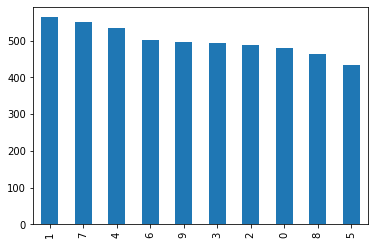

In [3]:
num_of_images = 5000
X_subset = X.iloc[:num_of_images, :]
y_subset = y[:num_of_images]
print("Subset images shape: ", X_subset.shape)
print("Subset labels shape: ", y_subset.shape)
y_subset.value_counts().plot(kind='bar')

## Preprocessing

In [5]:
scaler = StandardScaler()
scaler.fit(X_subset)
X_subset_transformed = scaler.transform(X_subset)
print(X_subset_transformed.shape)

(5000, 784)


## Perform t-SNE

### t-SNE

In [21]:
# Perform t-SNE with 2 dimensions
tsne = TSNE(n_components=2, n_iter=800, perplexity=50)
X_tsne = tsne.fit_transform(X_subset_transformed)

# convert the transformed data into dataframe
tsne_df = pd.DataFrame(np.column_stack((X_tsne, y_subset)), columns=["X", "Y", "labels"])
tsne_df.loc[:, "labels"] = tsne_df.labels.astype(int)
# tsne_df.head(10)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<Figure size 720x576 with 0 Axes>

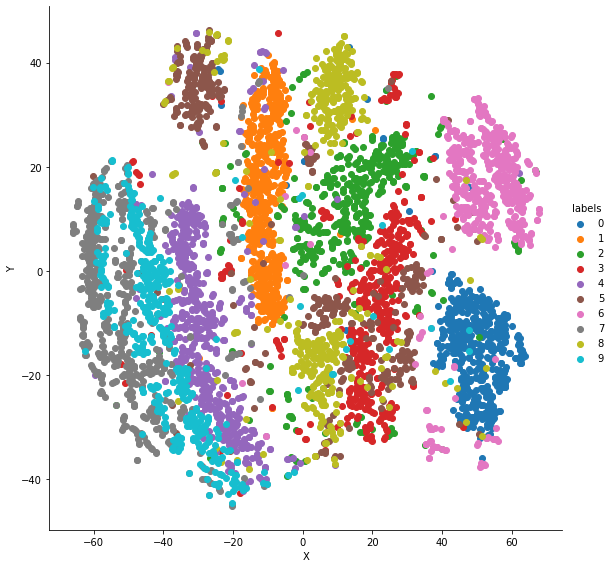

In [22]:
plt.figure(figsize=(10,8))
g = sns.FacetGrid(data=tsne_df, hue='labels', height=8)
g.map(plt.scatter, 'X', 'Y', cmap='Spectral').add_legend()
plt.show()

### t-SNE + PCA

Number of components explaining 95% variance: 141




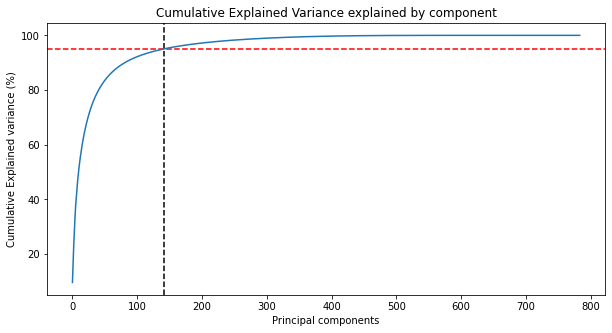

In [ ]:
pca = PCA()
pca.fit(X_transformed)

# Getting the cumulative variance
var_cumu = np.cumsum(pca.explained_variance_ratio_)*100

# How many PCs explain 95% of the variance?
k = np.argmax(var_cumu>95)
print("Number of components explaining 95% variance: "+ str(k))
print("\n")

plt.figure(figsize=[10,5])
plt.title('Cumulative Explained Variance explained by component')
plt.ylabel('Cumulative Explained variance (%)')
plt.xlabel('Principal components')
plt.axvline(x=k, color="k", linestyle="--")
plt.axhline(y=95, color="r", linestyle="--")
ax = plt.plot(var_cumu)

In [ ]:
pca = PCA(n_components=141)
pca.fit(X_transformed)
X_transformed = pca.transform(X_transformed)
X_transformed.shape

(10000, 141)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


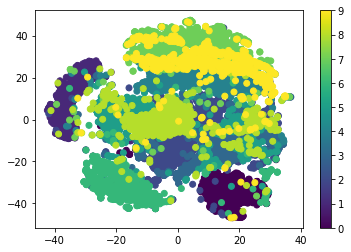

In [ ]:
# Perform t-SNE with 2 dimensions
tsne = TSNE(n_components=2, n_iter=600, perplexity=60)
X_pca_tsne = tsne.fit_transform(X_transformed)
# Plot the results
plt.scatter(X_pca_tsne[:, 0], X_pca_tsne[:, 1], c=y_small.astype(int).to_numpy(), cmap='Spectral', s=5)
plt.colorbar()
plt.show()

In [ ]:
X_transformed.shape

(2000, 141)

## Spectral clustering v1

In [23]:
n_cluster = 10
X_tsne_arr = tsne_df.loc[:, ['X', 'Y']].to_numpy()
print("Input shape: ",X_tsne_arr.shape)
print("-------------------------")

# Similarity matrix
# similarity_matrix = np.dot(X_tsne_arr, X_tsne_arr.T)
# RBF
sigma = 100
similarity_matrix = np.exp(-np.linalg.norm(X_tsne_arr[:, np.newaxis] - X_tsne_arr, axis=2) ** 2 / (2 * sigma ** 2))
print("Similarity matrix shape: ", similarity_matrix.shape)
print(similarity_matrix)
print("-------------------------")
# Degree matrix
degree_matrix = np.diag(np.sum(similarity_matrix, axis=1))
print("Degree matrix shape: ", degree_matrix.shape)
print(degree_matrix)
print("-------------------------")
# Laplacian matrix
laplacian_matrix = degree_matrix - similarity_matrix
print("Laplacian matrix shape: ", laplacian_matrix.shape)
print(laplacian_matrix)
print("-------------------------")

Input shape:  (5000, 2)
-------------------------
Similarity matrix shape:  (5000, 5000)
[[1.         0.86440391 0.69857091 ... 0.98180814 0.89562156 0.96603853]
 [0.86440391 1.         0.79214917 ... 0.89810795 0.79409985 0.87256667]
 [0.69857091 0.79214917 1.         ... 0.80651712 0.8808737  0.83363522]
 ...
 [0.98180814 0.89810795 0.80651712 ... 1.         0.95243474 0.99572306]
 [0.89562156 0.79409985 0.8808737  ... 0.95243474 1.         0.97610506]
 [0.96603853 0.87256667 0.83363522 ... 0.99572306 0.97610506 1.        ]]
-------------------------
Degree matrix shape:  (5000, 5000)
[[4203.92133102    0.            0.         ...    0.
     0.            0.        ]
 [   0.         4071.00838465    0.         ...    0.
     0.            0.        ]
 [   0.            0.         4238.98636514 ...    0.
     0.            0.        ]
 ...
 [   0.            0.            0.         ... 4470.47931074
     0.            0.        ]
 [   0.            0.            0.         ...    0.

In [24]:

# Eigenvectors and eigenvalues
eigenvalues, eigenvectors = np.linalg.eig(laplacian_matrix)
print("eigenvalues shape: ", eigenvalues.shape)
print(eigenvalues)
print("-------------------------")
print("eigenvectors shape: ", eigenvectors.shape)
print(eigenvectors)
print("-------------------------")
# get real from complex values
eigenvectors = eigenvectors.real


eigenvalues shape:  (5000,)
[1.44904592e-14 3.55615095e+03 3.71052122e+03 ... 4.36249013e+03
 4.36246075e+03 4.36246974e+03]
-------------------------
eigenvectors shape:  (5000, 5000)
[[-1.41421356e-02 -7.05979073e-03  1.77758928e-04 ... -5.34819362e-05
   4.79841681e-05 -3.94089176e-05]
 [-1.41421356e-02 -1.69656687e-02  5.97583924e-04 ... -3.69462059e-05
   2.16460458e-05 -2.46776148e-05]
 [-1.41421356e-02  4.01220107e-03  5.53746147e-05 ... -2.74411853e-05
   2.17547221e-06 -5.67512297e-05]
 ...
 [-1.41421356e-02 -3.20189179e-03  1.03490253e-04 ...  6.00939143e-05
  -5.18697309e-05  5.94596746e-05]
 [-1.41421356e-02  3.05443021e-03 -2.89860108e-05 ... -2.96019885e-06
  -3.89297771e-06  2.54084627e-05]
 [-1.41421356e-02 -1.18307904e-03  5.92990839e-05 ...  2.63319212e-05
  -2.53750275e-05  3.49693520e-05]]
-------------------------


In [25]:
# Sort the eigenvectors by their corresponding eigenvalues
idx = eigenvalues.argsort()
print(idx)
print("-------------------------")
sorted_eigenvectors = eigenvectors[:,idx]
print("eigenvectors shape: ",sorted_eigenvectors.shape)
print("sorted eigenvectors")
print(sorted_eigenvectors)

[  0   1   2 ... 278 277 276]
-------------------------
eigenvectors shape:  (5000, 5000)
sorted eigenvectors
[[-1.41421356e-02 -7.05979073e-03  1.77758928e-04 ... -2.48442684e-05
   3.50995987e-05  8.76092228e-06]
 [-1.41421356e-02 -1.69656687e-02  5.97583924e-04 ... -2.54296295e-05
   2.89226096e-05  7.40014754e-06]
 [-1.41421356e-02  4.01220107e-03  5.53746147e-05 ... -4.60800577e-05
   5.80285664e-05  1.41054410e-05]
 ...
 [-1.41421356e-02 -3.20189179e-03  1.03490253e-04 ... -9.61267679e-05
   1.31409500e-04  3.24753677e-05]
 [-1.41421356e-02  3.05443021e-03 -2.89860108e-05 ... -2.48426077e-04
   3.58132944e-04  8.63084610e-05]
 [-1.41421356e-02 -1.18307904e-03  5.92990839e-05 ... -1.79351181e-04
   2.49630141e-04  6.11893729e-05]]


In [53]:
# Select the k smallest eigenvectors
k_eigenvectors = sorted_eigenvectors[:,:2]
print(k_eigenvectors.shape)
# Normalize the eigenvectors
normalized_k_eigenvectors = k_eigenvectors / np.linalg.norm(k_eigenvectors, axis=0)
# Perform k-means clustering on the eigenvectors
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, init='k-means++').fit(k_eigenvectors)
y_pred = kmeans.labels_

unique, counts = np.unique(y_pred, return_counts=True)
result = np.column_stack((unique, counts)) 
print(result)
y_pred

(5000, 2)
[[   0 1123]
 [   1  479]
 [   2  166]
 [   3  524]
 [   4  100]
 [   5  909]
 [   6  215]
 [   7   13]
 [   8 1178]
 [   9  293]]


array([8, 3, 0, ..., 8, 0, 8], dtype=int32)

<Figure size 720x576 with 0 Axes>

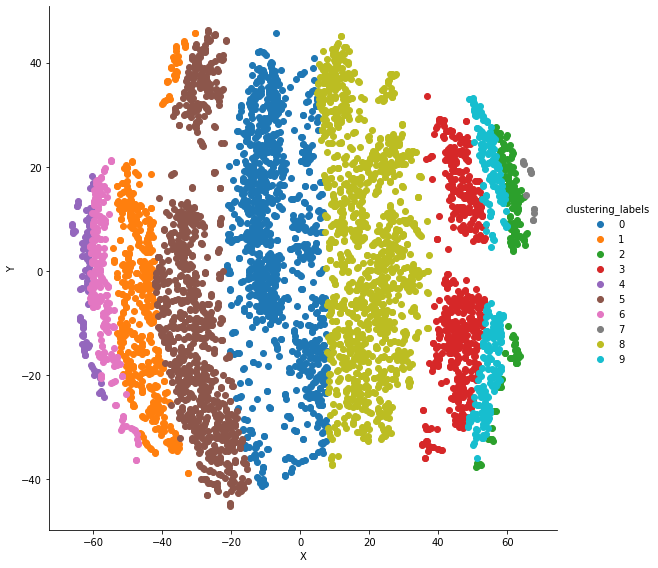

In [54]:
clustering_results_df = pd.DataFrame(np.column_stack((X_tsne, kmeans.labels_)), columns=["X", "Y", "clustering_labels"])
clustering_results_df.loc[:, "clustering_labels"] = clustering_results_df.clustering_labels.astype(int)
clustering_results_df.head(10)
plt.figure(figsize=(10,8))
g = sns.FacetGrid(data=clustering_results_df, hue='clustering_labels', height=8)
g.map(plt.scatter, 'X', 'Y', cmap='Spectral').add_legend()
plt.show()

### Kmeans fine tuning

In [88]:
from sklearn.metrics import silhouette_score

range_n_clusters = [6,8,10,12,14]

for n_clusters in tqdm(range_n_clusters, total=len(range_n_clusters)):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=0)
    kmeans.fit(k_eigenvectors)
    labels = kmeans.labels_
    score = silhouette_score(k_eigenvectors, labels, metric='euclidean')
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

 20%|██        | 1/5 [00:00<00:03,  1.32it/s]

For n_clusters = 6, silhouette score is 0.3789124183194386)


 40%|████      | 2/5 [00:01<00:01,  1.54it/s]

For n_clusters = 8, silhouette score is 0.4785671203697638)


 60%|██████    | 3/5 [00:02<00:01,  1.42it/s]

For n_clusters = 10, silhouette score is 0.5970975685171381)


 80%|████████  | 4/5 [00:02<00:00,  1.43it/s]

For n_clusters = 12, silhouette score is 0.5653739066017762)


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]

For n_clusters = 14, silhouette score is 0.555474456903025)


In [89]:
init_params = ['k-means++', 'random']
for init_param in tqdm(init_params, total=len(init_params)):
    kmeans = KMeans(n_clusters=10, init=init_param, random_state=0)
    kmeans.fit(k_eigenvectors)
    labels = kmeans.labels_
    score = silhouette_score(k_eigenvectors, labels, metric='euclidean')
    print("For init_param = {}, silhouette score is {})".format(init_param, score))

 50%|█████     | 1/2 [00:00<00:00,  1.60it/s]

For init_param = 14, silhouette score is 0.5970975685171381)


100%|██████████| 2/2 [00:01<00:00,  1.91it/s]

For init_param = 14, silhouette score is 0.5285657049315429)


In [43]:
from sklearn.metrics import silhouette_score
n_inits = [10, 30, 50]
for n_init in tqdm(n_inits, total=len(n_inits)):
    kmeans = KMeans(n_clusters=10, init='k-means++', random_state=0, n_init=n_init)
    kmeans.fit(k_eigenvectors)
    labels = kmeans.labels_
    score = silhouette_score(k_eigenvectors, labels, metric='euclidean')
    print("For n_init = {}, silhouette score is {})".format(n_init, score))

 33%|███▎      | 1/3 [00:01<00:02,  1.31s/it]

For n_init = 10, silhouette score is 0.5715698130694091)


 67%|██████▋   | 2/3 [00:05<00:02,  2.73s/it]

For n_init = 30, silhouette score is 0.5711899583682221)


100%|██████████| 3/3 [00:08<00:00,  2.97s/it]

For n_init = 50, silhouette score is 0.5711899583682221)


## Spectral clustering v2 (deprecated)

In [ ]:
from sklearn.neighbors import radius_neighbors_graph
from sklearn.neighbors import kneighbors_graph
print("X_tsne shape:", X_tsne.shape)
A = radius_neighbors_graph(X_tsne,0.4,mode='distance', metric='minkowski', p=2, metric_params=None, include_self=False)
# A = kneighbors_graph(X_mn, 2, mode='connectivity', metric='minkowski', p=2, metric_params=None, include_self=False)
A = A.toarray()
A.shape

X_tsne shape: (5000, 2)


(5000, 5000)

In [ ]:
A[:10,:10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
from scipy.sparse import csgraph
L = csgraph.laplacian(A, normed=False)
L[:5,:5]

array([[ 0.860752  , -0.        , -0.        , -0.        , -0.        ],
       [-0.        ,  0.37384045, -0.        , -0.        , -0.        ],
       [-0.        , -0.        ,  0.21432411, -0.        , -0.        ],
       [-0.        , -0.        , -0.        ,  0.56778201, -0.        ],
       [-0.        , -0.        , -0.        , -0.        ,  0.        ]])

In [ ]:
eigval, eigvec = np.linalg.eig(L)
np.where(eigval == np.partition(eigval, 1)[:10])# the second smallest eigenvalue

<ipython-input-21-32edeef263f6>:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  np.where(eigval == np.partition(eigval, 1)[:10])# the second smallest eigenvalue


(array([], dtype=int64),)

In [ ]:
eigvec[:,10]

array([-2.74971493e-16+0.j,  7.29517749e-15+0.j, -5.41732543e-16+0.j, ...,
        0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j])

In [ ]:
y_spec =eigvec[:,:10].copy().real
# y_spec[y_spec < 0] = 0
# y_spec[y_spec > 0] = 1
print(type(y_spec),y_subset.shape,y_spec.shape)
fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('Data with ground truth labels - linear separation not possible', fontsize=18, fontweight='demi')
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_subset ,s=5,cmap='Spectral')

SyntaxError: ignored

In [ ]:
# Perform k-means clustering on the eigenvectors
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10).fit(y_spec)
y_pred = kmeans.labels_
unique, counts = np.unique(y_pred, return_counts=True)
result = np.column_stack((unique, counts)) 
print(result)
y_pred

[[   0  153]
 [   1   92]
 [   2   23]
 [   3  163]
 [   4   85]
 [   5  128]
 [   6 4070]
 [   7  185]
 [   8   49]
 [   9   52]]


array([6, 6, 8, ..., 6, 6, 6], dtype=int32)